# Caso práctico 3 - Clasificación y Modelado de Temas

## Libraries & Misc

In [30]:
#!pip install -r requirements.txt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from tqdm import tqdm
import re  # Importar el módulo re
import os

tqdm.pandas()

### Directorios

In [2]:
dir = 'data/'
raw_dir = 'raw/'
processed_dir = 'processed/'
test_dir = 'test/'
train_dir = 'train/'

## Data Loading

Esta función nos permite cargar todos los ficheros .txt que tenemos y asignarlo a una tabla con el formato de:

id | category | train | corpus

en la que representan lo siguiente:
- **id**: representa el nombre del fichero .txt.
- **category**: la categoría que pertenece el fichero (business, sport, ...).
- **train**: si el fichero pertenece al conjunto preseparado de train o de test.
- **corpus**: el corpus del contenido del fichero .txt.


In [3]:
def load_data(base_dir):
    df = pd.DataFrame(columns=['id', 'category', 'train', 'corpus'])
    err = ''
    try:
        for train_test_dir in os.listdir(base_dir):
            for cat_dir in os.listdir(base_dir + train_test_dir):
                for text_file in os.listdir(base_dir + train_test_dir + '/' + cat_dir):
                    file_name = base_dir + train_test_dir + '/' + cat_dir + '/' + text_file
                    with open(base_dir + train_test_dir + '/' + cat_dir + '/' + text_file, 'r', encoding='utf-8', errors='replace') as file:
                        text = file.read()
                        # print(text)
                        # print('----------------------')
                        df.loc[len(df)] = {'id': text_file, 'category': cat_dir, 'train': train_test_dir, 'corpus': text}
                    print

        return df

    except Exception as e:
        print(e)
        print(file_name)

Hacemos un pequeño cambio a la columna train porque como guarda los nombres de los directorios, en la columna train lo guarda como los nombre de los directorios. Debido a esto, en vez de tene valores 1 o 0, nos aparece el nombre del directorio, por lo que nos dificultará el procesamiento posterior.

In [4]:
# change df[train] values to 1 or 0 depending if it is bbc_train or bbc_test respectively
def change_train_to_int(df):
    df['train'] = df['train'].apply(lambda x: 1 if x == 'bbc-train' else 0)
    return df

Guardamos el df en fichero para no tener que realizar el procesamiento todas las veces

In [5]:
df = load_data(dir + raw_dir)
df = change_train_to_int(df)
os.makedirs(dir + processed_dir, exist_ok=True)
df.to_csv(dir + processed_dir + 'df_raw', index=False)

In [6]:
df = pd.read_csv(dir + processed_dir + 'df_raw')

In [7]:
df.head(3)

,id,category,train,corpus
0,024.txt,business,0,US trade gap hits record in 2004\n\nThe gap be...
1,025.txt,business,0,Yukos loses US bankruptcy battle\n\nA judge ha...
2,026.txt,business,0,Safety alert as GM recalls cars\n\nThe world's...


## EDA

### Distribuciones de datos

Hacemos inicialmente un estudio de distribución de los datos y se observa lo siguiente:
* La distribución de la columna categoría tiene una distribución bastante uniforme y balanceada.
* El ratio de train test pre separado es de 90:10 aproximadamente.

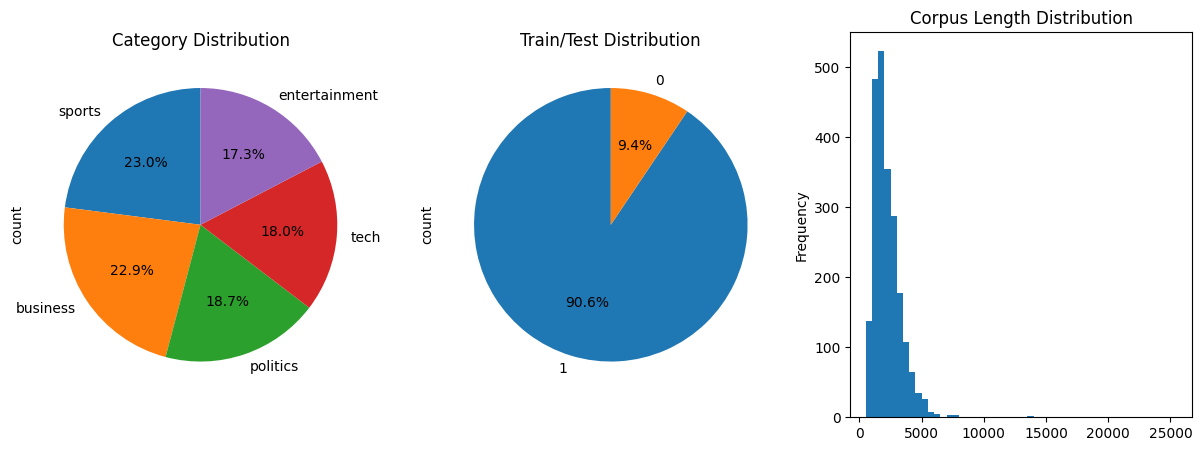

In [8]:
# plot category distribution as pie chart of columns category, train and len(corpus)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
df['category'].value_counts().plot.pie(ax=ax[0], autopct='%1.1f%%', startangle=90, title='Category Distribution')
df['train'].value_counts().plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90, title='Train/Test Distribution')
df['len'] = df['corpus'].apply(len)
df['len'].plot.hist(ax=ax[2], bins=50, title='Corpus Length Distribution')
plt.show()

Ahora realizamos el mismo proceso pero separando en los conjuntos train y test, para ver si la distribución varía entre estas.

C:\Users\NoobG\AppData\Local\Temp\ipykernel_13872\3329944406.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['train']==1]['len'] = df['corpus'].apply(len)


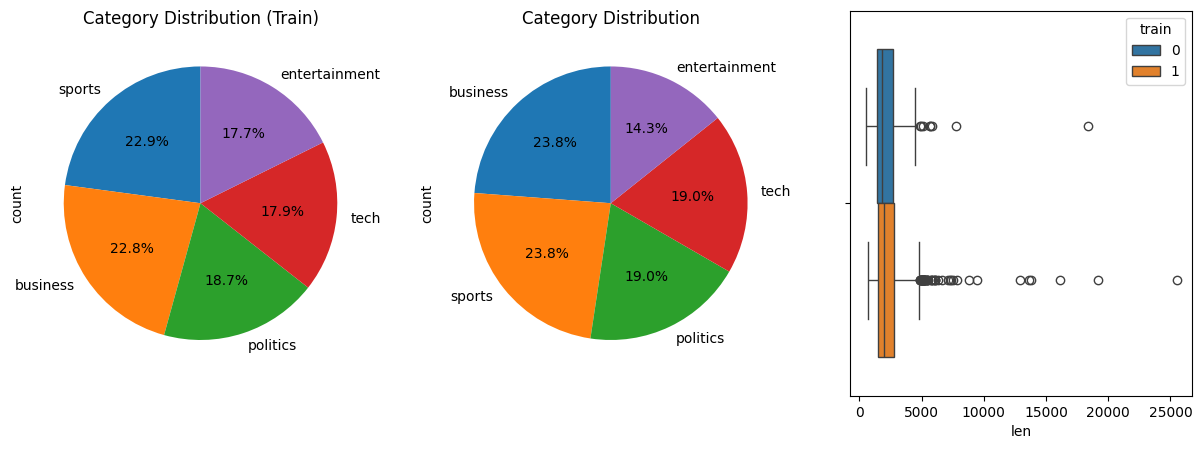

In [9]:
# plot category distribution as pie chart of columns category, train and len(corpus) but filtering by the train column
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
df[df['train']==1]['category'].value_counts().plot.pie(ax=ax[0], autopct='%1.1f%%', startangle=90, title='Category Distribution (Train)')
df[df['train']==0]['category'].value_counts().plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90, title='Category Distribution')
df[df['train']==1]['len'] = df['corpus'].apply(len)
# df[df['train']==1]['len'].plot.hist(ax=ax[2], bins=50, title='Corpus Length Distribution', hue='Train')
sns.boxplot(data=df, x='len', hue='train')
plt.show()

Se observa que las distribuciones se mantienen más o menos constante, en tanto las categorías como las longitudes de corpus de manera general.

Ahora comprobaremos las longitudes de las diferentes categorías

<Axes: xlabel='len', ylabel='category'>

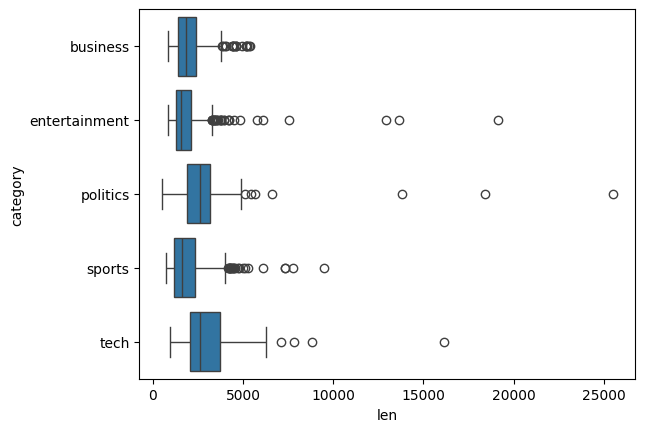

In [10]:
sns.boxplot(data=df, x='len', y='category')

Se observa que a pesar de que a pesar de que en grandes rasgos tienen un rango similar, si nos fijamos detalladamente, se puede observarq ue si que hay una diferencia más notable. Esto se observa precisamente en caso de tech que tiene en media y en rango IQR, mayor longitud que los de deporte, entretenimiento y business.

### Conclusión (EDA)

Hemos visto en el apartado de EDA que no hay desbalance significativo aparte de la diferencia en la longitud de las oraciones.

Nota: Las longitudes son de corpus absoluto, lo cual incluye espacios, "\n" entre otros caracteres especiales. Pero esto nos sirve para tener un conocimiento aproximado.

## Preprocessing

### Libraries

In [11]:
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression  # Ejemplo de clasificador
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

C:\Users\NoobG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Cleaning

Utilizamos la libreria de spacy para limpiar el texto y obtener los tokens.

Esta función lo que hace es mediante el uso de la libreria spacy, filtramos los tokens (palabras o elementos) que sean stop words, signos de puntuación (signos monetarios) y espacios.

Mantenemos los casos los signos monetarios porque podría dar más información del contexto del topic.

In [12]:
nlp = spacy.load("en_core_web_sm")  # Usa 'en_core_web_md' o 'en_core_web_lg' para modelos más grandes

def tokenizer(text):
    """
    Limpia un texto
    """
    doc = nlp(text)

    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]

    return tokens

In [13]:
def token_to_corpus(token_list):
    """
    Convierte una lista de tokens en un texto
    """
    return " ".join(token_list)

In [14]:
df['tokens'] = df['corpus'].progress_apply(tokenizer)

100%|██████████| 2225/2225 [02:31<00:00, 14.71it/s]


In [15]:
df['corpus'] = df['tokens'].progress_apply(token_to_corpus)

100%|██████████| 2225/2225 [00:00<00:00, 104269.47it/s]


In [16]:
df['corpus'][0]

'trade gap hit record 2004 gap export import hit time high $ 671.7bn £ 484bn 2004 late figure commerce department say trade deficit year 24.4 previous record 2003 imbalance $ 496.5bn deficit china 30.5 $ 162bn large record single country monthly basis trade gap narrow 4.9 december £ 56.4bn consumer appetite thing oil import car wine cheese reach record level year figure likely spark fresh criticism president bush economic policy democrats claim administration clamp unfair foreign trade practice example believe china currency policy manufacturer claim undervalue yuan 40 give china rapidly expand economy unfair advantage competitor bush administration argue deficit reflect fact america grow fast rate rest world spur demand import good economist allow upward revision economic growth fourth quarter point deficit reach astronomical proportion foreigner choose hold dollar denominate asset turn harm growth 2004 export rise 12.3 $ 1.15 trillion import rise fast 16.3 new record $ 1.76 trillion 

In [17]:
df['tokens'][0]

['trade',
 'gap',
 'hit',
 'record',
 '2004',
 'gap',
 'export',
 'import',
 'hit',
 'time',
 'high',
 '$',
 '671.7bn',
 '£',
 '484bn',
 '2004',
 'late',
 'figure',
 'commerce',
 'department',
 'say',
 'trade',
 'deficit',
 'year',
 '24.4',
 'previous',
 'record',
 '2003',
 'imbalance',
 '$',
 '496.5bn',
 'deficit',
 'china',
 '30.5',
 '$',
 '162bn',
 'large',
 'record',
 'single',
 'country',
 'monthly',
 'basis',
 'trade',
 'gap',
 'narrow',
 '4.9',
 'december',
 '£',
 '56.4bn',
 'consumer',
 'appetite',
 'thing',
 'oil',
 'import',
 'car',
 'wine',
 'cheese',
 'reach',
 'record',
 'level',
 'year',
 'figure',
 'likely',
 'spark',
 'fresh',
 'criticism',
 'president',
 'bush',
 'economic',
 'policy',
 'democrats',
 'claim',
 'administration',
 'clamp',
 'unfair',
 'foreign',
 'trade',
 'practice',
 'example',
 'believe',
 'china',
 'currency',
 'policy',
 'manufacturer',
 'claim',
 'undervalue',
 'yuan',
 '40',
 'give',
 'china',
 'rapidly',
 'expand',
 'economy',
 'unfair',
 'advant

Decidimos mantener los simbolos especiales como $ porque creemos que puede tener impacto entre diferentes topics


#### N-Gramas

Procedemos a obtener bigramas y trigramas.

In [ ]:
df['bigrams'] = df['tokens'].progress_apply(lambda x: list(nltk.bigrams(x)))
df['trigrams'] = df['tokens'].progress_apply(lambda x: list(nltk.trigrams(x)))

### Analisis con Word Cloud

Ahora que tenemos los elementos tokenizados, vamos a hacer un análisis con word cloud para ver la frecuencia y relevancia de las palabras en el corpus con todas las categorías.

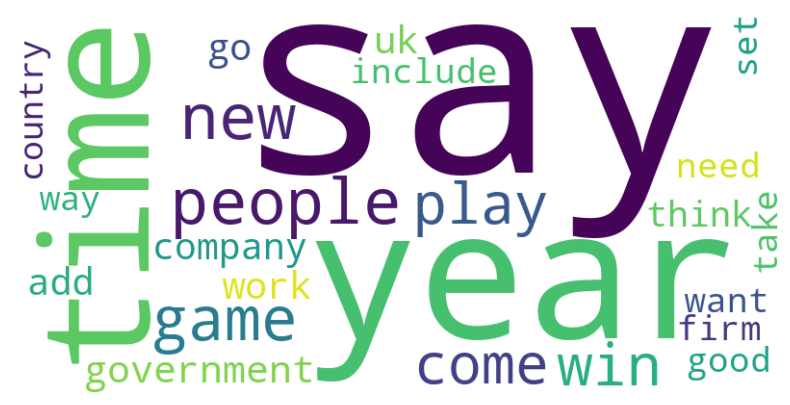

In [18]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# all_tokens es la lista aplanada de todos los tokens (ya limpios)

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=25)
wordcloud.generate(" ".join(df['tokens'].sum()))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Ahora realizamos un estudio de las palabras mas comunes por categoría, en la cual podemos observar que hay palabras (verbos) que se aparecen con una alta fracuencia en todas, como "say". Sin embargo, se ve que en general las palabras con mayor frecuencia de las diferentes categorías tienden a ser bastante diferenciables.

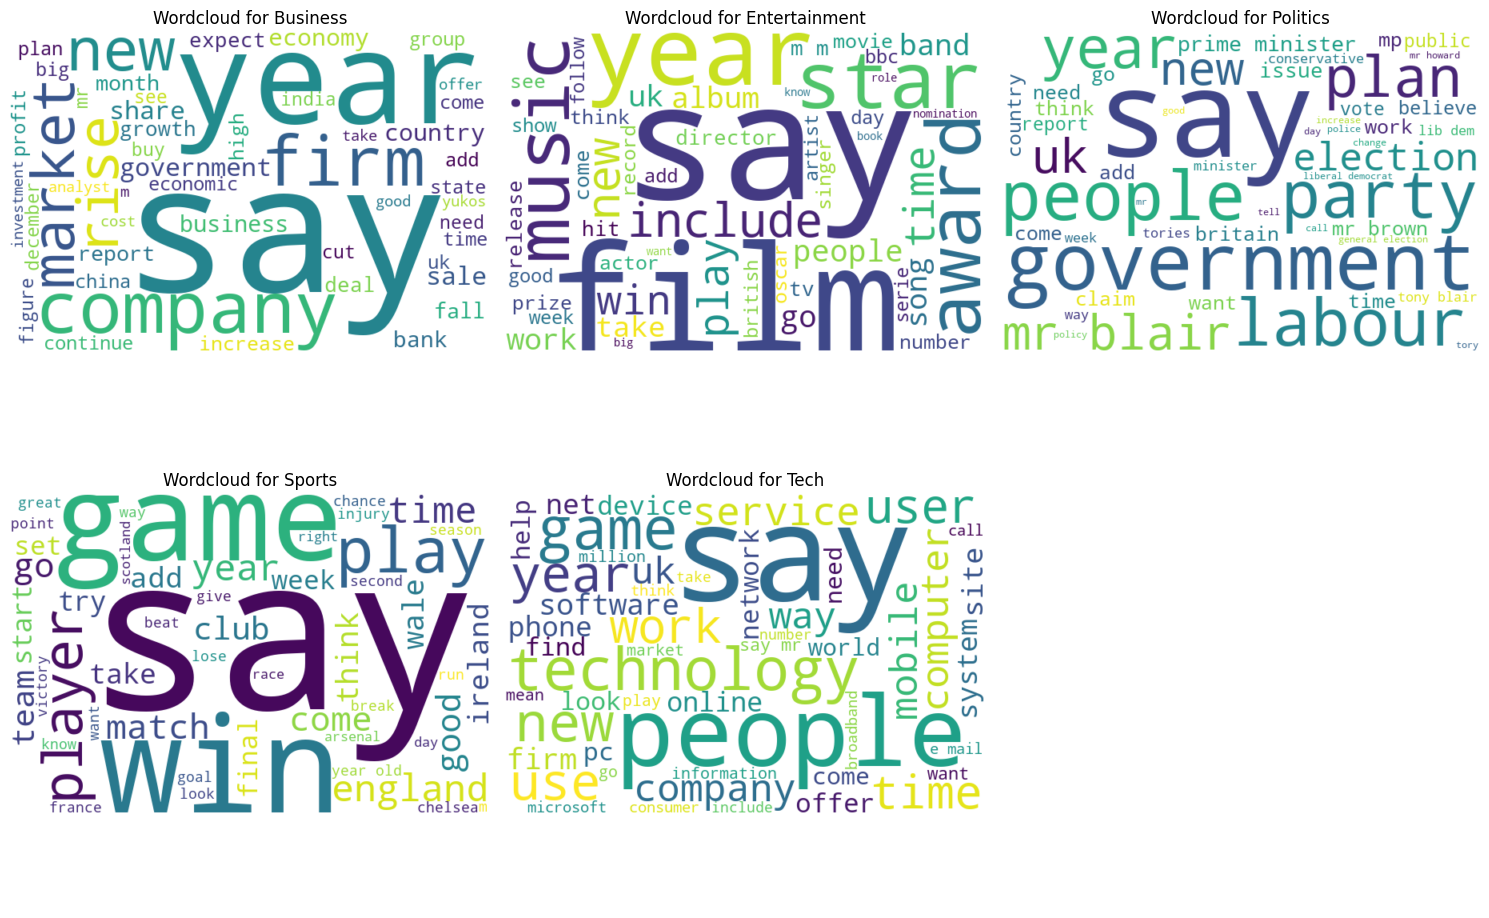

In [19]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust figsize as needed.
axes = axes.flatten()


# all_tokens es la lista aplanada de todos los tokens (ya limpios)
for i, category in enumerate(df['category'].unique()):
    wordcloud = WordCloud(width=600, height=400, background_color='white', max_words=50)
    wordcloud_df = df[df['category'] == 'business']
    
    wordcloud.generate(" ".join(df[df['category'] == category]['tokens'].sum()))

    ax = axes[i]  # Get the *current* subplot.
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Wordcloud for {category.capitalize()}')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## PABLO


Hacer NGRAMAS NLTK

Representación Vectorial:

Convierte el texto (listas de tokens) en vectores numéricos que los modelos de machine learning puedan entender.
Opciones (para Clasificación y Topic Modeling):
Bag of Words (BoW):  Crea un vector para cada documento que cuenta la frecuencia de cada token.  Simple pero pierde el orden de las palabras.

sklearn.feature_extraction.text.CountVectorizer: Transforma el texto en una matriz donde las filas son los documentos y las columnas son los tokens.
TF-IDF (Term Frequency-Inverse Document Frequency):  Similar a BoW, pero da más peso a las palabras que son frecuentes en un documento pero poco frecuentes en el corpus.

sklearn.feature_extraction.text.TfidfVectorizer: Transforma el texto en una matriz TF-IDF.
Word Embeddings (Pre-entrenados): Vectores densos que representan el significado de las palabras.  Word2Vec, GloVe, FastText.

spaCy: Ya incluye embeddings (si usas un modelo mediano o grande, como en_core_web_md o en_core_web_lg). Puedes obtener el vector de un token con token.vector, o el vector de un documento completo con doc.vector (promedia los vectores de los tokens).
Gensim: gensim.models.Word2Vec, gensim.models.FastText. Puedes entrenar tus propios embeddings o cargar modelos pre-entrenados.
Para clasificación, con embeddings, sueles necesitar:
Promediar los vectores de los tokens de cada documento para obtener un vector que represente todo el documento (es lo más simple).
Usar una red neuronal recurrente (RNN) o un Transformer, que pueden procesar secuencias de vectores de longitud variable.
Word Embeddings (Entrenados desde cero en tu corpus): Se hace igual que con los pre entrenados, solo que los entrenas con tu corpus en Gensim por ejemplo.

Embeddings a nivel de documento (Doc2Vec): Extensión de Word2Vec que aprende un vector para cada documento (además de los vectores de palabras).

Gensim gensim.models.doc2vec.Doc2Vec
Modelos de lenguaje basados en Transformers (BERT, RoBERTa, etc.):  Representaciones vectoriales contextualizadas muy potentes.
* Hugging Face transformers: Librería para usar estos modelos.

Para Topic Modeling (Adicional):

Latent Dirichlet Allocation (LDA): Un modelo probabilístico que asume que cada documento es una mezcla de tópicos, y cada tópico es una distribución de probabilidad sobre palabras.
sklearn.decomposition.LatentDirichletAllocation: Implementación de LDA. Requiere como entrada una matriz BoW o TF-IDF.
gensim.models.LdaModel: Otra implementación de LDA. También requiere una representación BoW (creada con gensim.corpora.Dictionary).
Non-negative Matrix Factorization (NMF): Otra técnica de reducción de dimensionalidad que se puede usar para topic modeling.
sklearn.decomposition.NMF: Implementación de NMF. También requiere BoW o TF-IDF.
Embeddings, transformers... Técnicamente sí, pero se usan más para clasificación.


--- NGRAMAS + VECTORIZACIÓN ---

In [20]:
from nltk import ngrams
from collections import Counter

In [21]:
# Lista aplanada de todos los tokens
all_tokens = df['tokens'].sum()

# Generar bigramas y contar frecuencia
bigrams = list(ngrams(all_tokens, 2))
bigram_freq = Counter(bigrams).most_common(10)

# Mostrar los 10 bigramas más frecuentes
for (w1, w2), freq in bigram_freq:
    print(f"{w1} {w2}: {freq}")


say mr: 400
tell bbc: 365
year old: 344
mr blair: 331
prime minister: 321
m £: 258
mr brown: 255
e mail: 229
chief executive: 208
tony blair: 186


Bag of Words y TF-IDF con n-gramas

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [23]:
ngram_range = (1, 2)

# Bag of Words con n-gramas
bow_vectorizer = CountVectorizer(ngram_range=ngram_range)
X_bow = bow_vectorizer.fit_transform(df['corpus'])

# TF-IDF con n-gramas
tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range)
X_tfidf = tfidf_vectorizer.fit_transform(df['corpus'])


Modelado de Temas con LDA (BoW)

In [24]:
from sklearn.decomposition import LatentDirichletAllocation

TODO: Por que se ha elegido ncomponents
Probar diferentes ngramas con diferentes metricas: coherence score y Davies Boulding Index, Perplexity

In [25]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X_bow)

feature_names = bow_vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]
    print(f"🔹 Topic {idx + 1}: {', '.join(top_words)}")

🔹 Topic 1: government, tell, win, go, people, good, new, year, mr, say
🔹 Topic 2: phone, mr, take, mobile, time, game, new, people, year, say
🔹 Topic 3: growth, sale, rise, time, people, mr, new, game, year, say
🔹 Topic 4: work, firm, service, site, time, new, mr, people, year, say
🔹 Topic 5: game, election, government, labour, good, new, win, year, mr, say


Modelado de Temas con NMF (TF-IDF)

In [26]:
from sklearn.decomposition import NMF

In [27]:
nmf_model = NMF(n_components=5, random_state=42)
nmf_model.fit(X_tfidf)

feature_names = tfidf_vectorizer.get_feature_names_out()
for idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]
    print(f"🔹 Topic {idx + 1}: {', '.join(top_words)}")


🔹 Topic 1: software, digital, user, service, say, music, technology, people, phone, mobile
🔹 Topic 2: minister, mr brown, mr blair, brown, say, party, blair, election, labour, mr
🔹 Topic 3: cup, ireland, team, match, say, player, play, england, win, game
🔹 Topic 4: director, festival, actress, win, oscar, actor, star, good, award, film
🔹 Topic 5: sale, market, year, price, bank, rate, rise, economy, growth, say


Clasificación con TF-IDF + Regresión Logística

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [29]:
X = X_tfidf
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


               precision    recall  f1-score   support

     business       0.96      0.97      0.97       102
entertainment       0.97      1.00      0.99        77
     politics       0.98      0.98      0.98        84
       sports       0.99      0.99      0.99       102
         tech       0.99      0.95      0.97        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



## FIN PABLO

##